# Machine Learning Algorithm - Decision Trees, Tree Ensemble
In this note book using the Heart Failure Prediction Dataset, we will experiment with Supervised Learning model Decision Trees and Tree Ensemble


In [1]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv("data/heart.csv")

In [3]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


###  1.Use one-hot encoding to convert the categorical variables such as Sex, RestingEEG to numeric

one-hot encoding transforms a categorical variable with n output into n binary (0,1) variables

In [4]:
cat_variables = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

# use pd.get_dummies for one-hot encoding

df = pd.get_dummies(data=df, prefix=cat_variables, columns = cat_variables)

In [5]:
df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,...,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,1,0,0,...,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,0,1,0,...,0,0,0,0,1,1,0,0,0,1
3,48,138,214,0,108,1.5,1,1,0,1,...,0,0,0,1,0,0,1,0,1,0
4,54,150,195,0,122,0.0,0,0,1,0,...,1,0,0,1,0,1,0,0,0,1


### 2. Extract features from the dataset

In [6]:
# Extract the features form the dataset by removing the target variable HeartDisease
features = [x for x in df.columns if x not in 'HeartDisease']

In [7]:
# one hot encoding increased the number of columns to 20 in the feature
print(len(features))

20


In [8]:
# create input X
X= df[features]

In [9]:
X.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,1,0,1,0,0,0,1,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,0,0,0,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,1,0,1,0,0,0,0,1,1,0,0,0,1
3,48,138,214,0,108,1.5,1,0,1,0,0,0,0,1,0,0,1,0,1,0
4,54,150,195,0,122,0.0,0,1,0,0,1,0,0,1,0,1,0,0,0,1


In [10]:
# create target y
y=df['HeartDisease']

In [11]:
y.head()

0    0
1    1
2    0
3    1
4    0
Name: HeartDisease, dtype: int64

### 3. Split data into training and validation set

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size =.8, random_state=55)

In [13]:
print(f'training samples: {len(X_train)}')
print(f'validation samples: {len(X_val)}')
print(f'target prpportion: {sum(y_train)/len(y_train):,.4f}')


training samples: 734
validation samples: 184
target prpportion: 0.5518


# 4.Build the Models

## 4.1 Decision trees using scikit-learn

We will use the following hyperparamters:
- min_sample_split:  The minimum number of samples required to split a internal note.  
    - Choosing a higher value can reduce the number of splits; therefore help reduce overfitting.

- max_depth:  The maximum depth of the tree
    - Choosing a lower value can reduce the overall number of splits; therefore help reduce overfitting

In [14]:
# try a set of values hyperparameters for min_sample_split and max_depth
min_samples_split_list = [2,10, 30, 50, 100, 200, 300, 700]
max_depth_list = [1, 2, 3, 4, 8, 16, 32, None]  # None means that there is no depth limit

In [15]:
# build the model with different min_samples_split values and measure the accuracy score

accuracy_list_train = []
accuracy_list_val = []

for min_samples_split in min_samples_split_list:
    
    model = DecisionTreeClassifier(min_samples_split = min_samples_split,
                                  random_state = 55).fit(X_train, y_train)
    predictions_train = model.predict(X_train)  ## The predicted values for the train dataset
    predictions_val = model.predict(X_val)   ## The predicated values for the validation dataset
    accuracy_train = accuracy_score(predictions_train, y_train)
    accuracy_val = accuracy_score(predictions_val, y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)
    
    

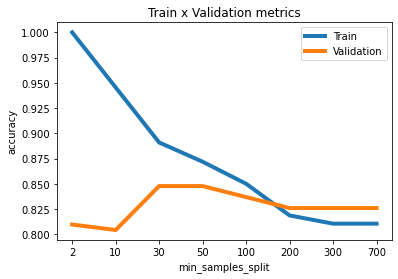

In [16]:
# plot accuracy vs min_samples_split

plt.title("Train x Validation metrics")
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(min_samples_split_list)), labels = min_samples_split_list)
plt.plot(accuracy_list_train, linewidth=4)
plt.plot(accuracy_list_val, linewidth=4)
plt.legend(['Train', 'Validation'])
plt.show()

Note that increasing min_samples_split will reduce the overfitting.  Train and validatio scores getting close to each other.  Notice that increasing it from 10 to 30 and 50 does not improve the validation accuracy my much it brings the training accuracy closer to it, showing a reduction in overfitting

Now let's try the same experiment with the max_depth hyperparameter


In [17]:
# build and fit the model with different max_depth values and measure the accuracy score

accuracy_list_train = []
accuracy_list_val = []

for max_depth in max_depth_list:
    
    model = DecisionTreeClassifier(max_depth = max_depth,
                                  random_state = 55).fit(X_train, y_train)
    predictions_train = model.predict(X_train)  ## The predicted values for the train dataset
    predictions_val = model.predict(X_val)   ## The predicated values for the validation dataset
    accuracy_train = accuracy_score(predictions_train, y_train)
    accuracy_val = accuracy_score(predictions_val, y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)
    

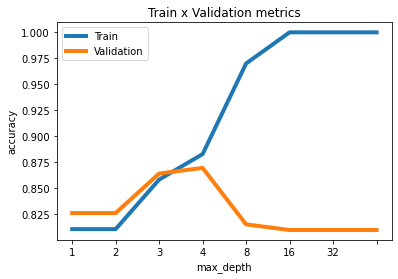

In [19]:
# plot accuracy vs max_depth

plt.title("Train x Validation metrics")
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(max_depth_list)), labels = max_depth_list)
plt.plot(accuracy_list_train, linewidth=4)
plt.plot(accuracy_list_val, linewidth=4)
plt.legend(['Train', 'Validation'])
plt.show()

Note that as max_depth decreases the validation accuracy improves and the it gets closer to the train accuracy
A few observations:

- Reducing max_depth from 8 to 4 increases validation accuracy closure the training accuracy, while significantly reducing training accuracy
- when max-depth <3 both validation and training accuracies decrease
- when max_depth >=5  validation accuracy decreases while training accuracy increases; thus indicating that the model is overfitting the trainig set


Therefore, based on the above graphs we decide to choose th efollwing values for our model:
- max_depth  = 4
- min_samples_split = 50

In [25]:
# build the decision tree classifier model 
decision_tree_model = DecisionTreeClassifier(min_samples_split = 50, max_depth=4, random_state=55)

In [26]:
# fit the model to the training set
decision_tree_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, min_samples_split=50, random_state=55)

In [27]:
# calculate accuracy
print("Decision Tree Classifier metrics:")
print(f"Medtrics train\n\tAccuracy score: {accuracy_score(decision_tree_model.predict(X_train),y_train):.4f}")
print(f"Medtrics validation\n\tAccuracy score: {accuracy_score(decision_tree_model.predict(X_val),y_val):.4f}")

Decision Tree Classifier metrics:
Medtrics train
	Accuracy score: 0.8665
Medtrics validation
	Accuracy score: 0.8696


As you can see there is no sign of overfitting, although the model is not very accurate

## 4.2 Random Forest
Next we build a random forest model using scikit-learn implementation

- In addition to all the hyperparameters found in the decision tree, Random Forest has a parameter called n_estimators.  n_estimatators determine the number of decision trees that make up the random forest.  

- In Random Forest model we randomly select a subset of features and randomly select a subset of training examples to train each individual tree.  

- ff n is the number of features, we select $\sqrt(n)$ of these features to train each individual tree.
- We will also use n_jobs parameter to fit more than one tree in parallel.  The higher the value of n_jobs will increase CPU cores in use

- We will use n_estimators = [10, 50, 100] 

In [28]:
min_samples_split_list = [2,10, 30, 50, 100, 200, 300, 700]  ## If the number is an integer, then it is the actual quantity of samples,
                                             ## If it is a float, then it is the percentage of the dataset
max_depth_list = [2, 4, 8, 16, 32, 64, None]
n_estimators_list = [10,50,100,500]

Now we build and fit our model and capture accuracy scores for each value of the min_samples_split 

In [29]:
accuracy_list_train = []
accuracy_list_val = []
for min_samples_split in min_samples_split_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(min_samples_split = min_samples_split,
                                   random_state = 55).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

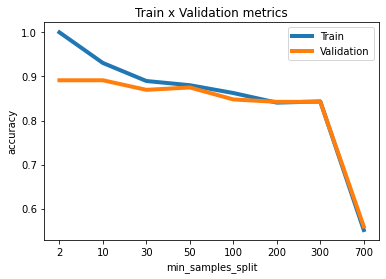

In [30]:
# We plot accuracy vs min_samples_split
plt.title('Train x Validation metrics')
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(min_samples_split_list )),labels=min_samples_split_list) 
plt.plot(accuracy_list_train, linewidth=4)
plt.plot(accuracy_list_val, linewidth=4)
plt.legend(['Train','Validation'])
plt.show()

It looks like the best value for the min_samples_split might be around 10. This is where the difference between training and validation has decreased showing less overfitting and the accuracy is close .90 for the validation set

In [31]:
# Let's try to build and fit the same model with different values of max_depth
accuracy_list_train = []
accuracy_list_val = []
for max_depth in max_depth_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(max_depth = max_depth,
                                   random_state = 55).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

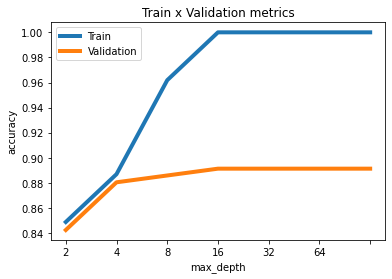

In [32]:
# plot accuracy vs max_depth
plt.title('Train x Validation metrics')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(max_depth_list )),labels=max_depth_list)
plt.plot(accuracy_list_train, linewidth=4)
plt.plot(accuracy_list_val, linewidth=4)
plt.legend(['Train','Validation'])
plt.show()

Looks like anything less that max_depth 16 will reduce the accuracy of the validation set. 

In [33]:
# Let's build and fit models for various values of the n_estimators and measure accuracy score
accuracy_list_train = []
accuracy_list_val = []
for n_estimators in n_estimators_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(n_estimators = n_estimators,
                                   random_state = 55).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

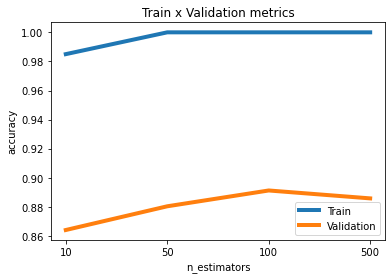

In [34]:
# plot accuracy vs. n_estimators
plt.title('Train x Validation metrics')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(n_estimators_list )),labels=n_estimators_list)
plt.plot(accuracy_list_train, linewidth=4)
plt.plot(accuracy_list_val, linewidth=4)
plt.legend(['Train','Validation'])
plt.show()

Looks like the validation accuracy incresaes up to 100, then decreases after that.  So we will go with 100

Therefore, we try to fit the random forest witht he following parameters:

- max_depth = 16
- min_samples_split: 10
- n_estimators = 100

In [ ]:
# We build the Random Forest model
random_forest_model = RandomForestClassifier(n_estimators = 100, max_depth=16, min_samples_split = 10)

In [ ]:
# We fit the model to the training set
random_forest_model.fit(X_train, y_train)

In [ ]:
# We measure accuracy
print("Random Forest Classifier Metrics:")
print(f"Metrics train acurracy score: {accuracy_score(random_forest_model.predict(X_train), y_train)}")
print(f"Metrics validation acurracy score: {accuracy_score(random_forest_model.predict(X_val), y_val)}")

Idealy we want to check combination of values for every hyper parameter that we are tuning.  IF we have 3 hyper parameters and each has 5 values we have a total of 5X5X5 = 125 combinations.

To try out all combinations we can use a sklearn implementation called GridSearchCV.  GridSearchCV has a refill parameter that will automatically refit a model on the best combination so we will not have to program it explicitly.  

In [ ]:
params_grid = {'max_depth': max_depth_list,
               'min_samples_split': min_samples_split_list,
               'n_estimators': n_estimators_list}

In [ ]:
random_forest_model = RandomForestClassifier()
grid_clf = GridSearchCV(random_forest_model, params_grid)

In [ ]:
grid_clf.fit(X_train, y_train)

In [ ]:
print("GridSearch CV metrics:")
print(f"Training accuracy: {accuracy_score(grid_clf.predict(X_train), y_train):.4f}")
print(f"Validation accuracy: {accuracy_score(grid_clf.predict(X_val), y_val):.4f}")

In [ ]:
grid_clf.best_params_

## 4.3 XGBoost
Next is the Gradient Boosting model, called XGBoost. The boosting methods train several trees, but instead of them being uncorrelated to each other, now the trees are fit one after the other in order to minimize the error.

The model has the same parameters as a decision tree, plus the learning rate.

The learning rate is the size of the step on the Gradient Descent method that the XGBoost uses internally to minimize the error on each train step.
One interesting thing about the XGBoost is that during fitting, it can take in an evaluation dataset of the form (X_val,y_val).

On each iteration, it measures the cost (or evaluation metric) on the evaluation datasets.
Once the cost (or metric) stops decreasing for a number of rounds (called early_stopping_rounds), the training will stop.
More iterations lead to more estimators, and more estimators can result in overfitting.
By stopping once the validation metric no longer improves, we can limit the number of estimators created, and reduce overfitting.
First, let's define a subset of our training set (we should not use the test set here).

In [ ]:
n = int(len(X_train)*0.8) ## Let's use 80% to train and 20% to eval

In [ ]:
X_train_fit, X_train_eval, y_train_fit, y_train_eval = X_train[:n], X_train[n:], y_train[:n], y_train[n:]

We can then set a large number of estimators, because we can stop if the cost function stops decreasing.

ote some of the `.fit()` parameters:
- `eval_set = [(X_train_eval,y_train_eval)]`:Here we must pass a list to the eval_set, because you can have several different tuples ov eval sets. 
- `early_stopping_rounds`: This parameter helps to stop the model training if its evaluation metric is no longer improving on the validation set. It's set to 10.
  - The model keeps track of the round with the best performance (lowest evaluation metric).  For example, let's say round 16 has the lowest evaluation metric so far.
  - Each successive round's evaluation metric is compared to the best metric.  If the model goes 10 rounds where none have a better metric than the best one, then the model stops training.
  - The model is returned at its last state when training terminated, not its state during the best round.  For example, if the model stops at round 26, but the best round was 16, the model's training state at round 26 is returned, not round 16.
  - Note that this is different from returning the model's "best" state (from when the evaluation metric was the lowest).

In [ ]:
xgb_model = XGBClassifier(n_estimators=500, learning_rate=0.1, verbosity=1, random_state=55, use_label_encoder=False)
xgb_model.fit(X_train_fit, y_train_fit, eval_set = [(X_train_eval, y_train_eval)], early_stopping_rounds=10)

Even though we initialized the model to allow up to 500 estimators, the algorithm only fit 26 estimators (over 26 rounds of training).

To see why, let's look for the round of training that had the best performance (lowest evaluation metric).  You can either view the validation log loss metrics that were output above, or view the model's `.best_iteration` attribute:

In [ ]:
xgb_model.best_iteration

The best round of training was round 16, with a log loss of 4.3948.  
- For 10 rounds of training after that (from round 17 to 26), the log loss was higher than this.
- Since we set `early_stopping_rounds` to 10, then by the 10th round where the log loss doesn't improve upon the best one, training stops.
- You can try out different values of `early_stopping_rounds` to verify this.  If you set it to 20, for instance, the model stops training at round 36 (16 + 20).

In [ ]:
print("XGBoost metrics:")
print(f"Training acurracy: {accuracy_score(xgb_model.predict(X_train), y_train): .4f}")
print(f"Validation acurracy: {accuracy_score(xgb_model.predict(X_val), y_val): .4f}")